In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emotion-detection-from-text/tweet_emotions.csv
/kaggle/input/glove6b50dtxt/glove.6B.50d.txt
/kaggle/input/emotions-dataset-for-nlp/val.txt
/kaggle/input/emotions-dataset-for-nlp/test.txt
/kaggle/input/emotions-dataset-for-nlp/train.txt


In [2]:
import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

In [4]:
stop_wrods = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [5]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.svm import SVC

In [6]:
from lime import lime_text
from lime.lime_text import LimeTextExplainer, IndexedString, IndexedCharacters, explanation
from lime.lime_base import LimeBase

sns.set(font_scale=1.3)
nltk.download('omw-1.4')


[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [7]:
df_train = pd.read_csv('/kaggle/input/emotions-dataset-for-nlp/train.txt', names=['Text', 'Emotion'], sep=';')
df_val = pd.read_csv('/kaggle/input/emotions-dataset-for-nlp/val.txt', names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv('/kaggle/input/emotions-dataset-for-nlp/test.txt', names=['Text', 'Emotion'], sep=';')

In [8]:
df_train.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [9]:
df_train['Emotion'].value_counts()

Emotion
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

In [10]:
print(df_test.shape)
df_test.head()

(2000, 2)


,Text,Emotion
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


In [11]:
print(df_val.shape)
df_val.head()

(2000, 2)


,Text,Emotion
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy


In [12]:
df_train['Emotion'].value_counts()

Emotion
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

In [13]:
df_train['Emotion'].value_counts() / df_train.shape[0] * 100

Emotion
joy         33.51250
sadness     29.16250
anger       13.49375
fear        12.10625
love         8.15000
surprise     3.57500
Name: count, dtype: float64

<Axes: xlabel='Emotion', ylabel='count'>

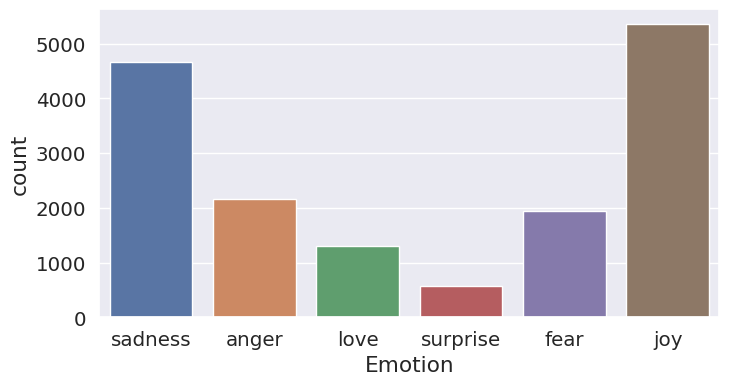

In [14]:
plt.figure(figsize=(8, 4))
sns.countplot(x='Emotion', data=df_train)

In [15]:
df_train.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [16]:
df_train.duplicated().sum()

1

In [17]:
index = df_train[df_train.duplicated() == True].index
df_train.drop(index, axis=0, inplace=True)
df_train.reset_index(inplace=True, drop=True)

In [18]:
df_train[df_train.duplicated() == True].index

Index([], dtype='int64')

In [19]:
df_train[df_train['Text'].duplicated() == True]

,Text,Emotion
5067,i feel on the verge of tears from weariness i ...,joy
6133,i still feel a craving for sweet food,love
6563,i tend to stop breathing when i m feeling stre...,anger
7623,i was intensely conscious of how much cash i h...,sadness
7685,im still not sure why reilly feels the need to...,surprise
8246,i am not amazing or great at photography but i...,love
9596,ive also made it with both sugar measurements ...,joy
9687,i had to choose the sleek and smoother feel of...,joy
9769,i often find myself feeling assaulted by a mul...,sadness
9786,i feel im being generous with that statement,joy


In [20]:
df_train[df_train['Text'] == df_train.iloc[7623]['Text']]

,Text,Emotion
1625,i was intensely conscious of how much cash i h...,anger
7623,i was intensely conscious of how much cash i h...,sadness


In [21]:
index = df_train[df_train['Text'].duplicated() == True].index
df_train.drop(index, axis=0, inplace=True)
df_train.reset_index(inplace=True, drop=True)

In [22]:
df_train[df_train['Text'].duplicated() == True]

,Text,Emotion


In [23]:
temp = df_train.copy()
stop_words = set(stopwords.words('english'))
temp['stop_words'] = temp['Text'].apply(lambda x : len(set(x.split()) & set(stop_words)))
temp['stop_words'].value_counts()

stop_words
5     1416
7     1405
6     1392
4     1341
8     1319
3     1263
9     1177
10    1048
2      922
11     889
12     752
13     644
14     493
1      450
15     376
16     265
17     238
18     164
19     113
20      90
0       79
21      60
22      33
23      19
24       7
25       6
26       6
28       1
29       1
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

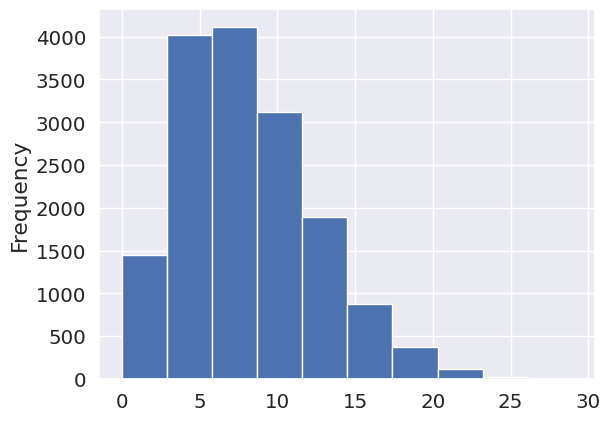

In [24]:
temp['stop_words'].plot(kind='hist')

In [25]:
df_test['Emotion'].value_counts()

Emotion
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64

<Axes: xlabel='Emotion', ylabel='count'>

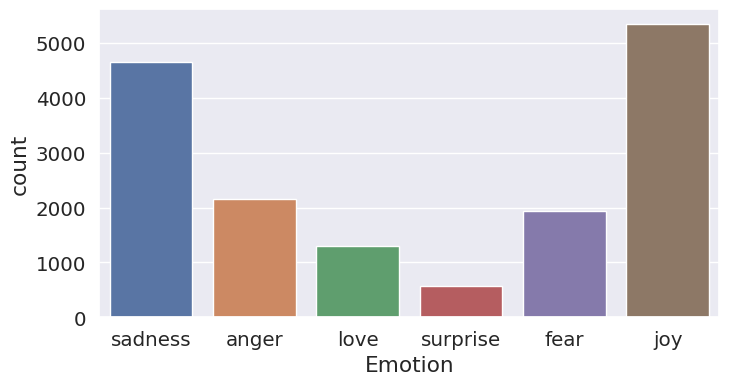

In [26]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df_train, x='Emotion')

In [27]:
df_test.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [28]:
df_test.duplicated().sum()

0

In [29]:
df_test[df_test['Text'].duplicated() == True].index

Index([], dtype='int64')

In [30]:
temp = df_test.copy()
temp['stop_words'] = temp['Text'].apply(lambda x : len(set(x.split()) & set(stop_words)))
temp['stop_words'].value_counts()

stop_words
7     184
6     179
3     175
5     175
4     163
9     163
8     139
10    123
2     118
11    115
12     84
13     71
15     61
14     58
1      42
16     40
17     31
18     22
20     17
19     11
21     10
0       8
23      7
24      2
22      2
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

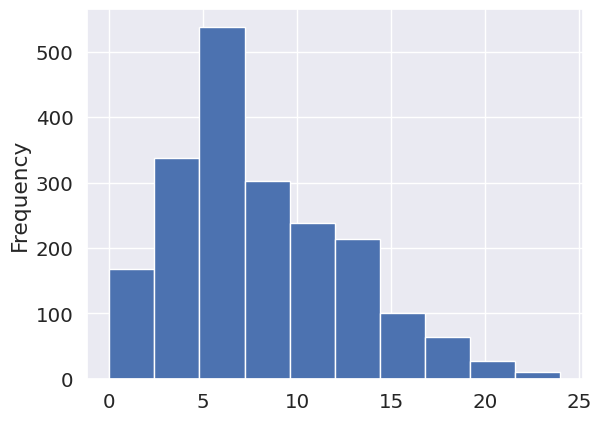

In [31]:
sns.set(font_scale=1.3)
temp['stop_words'].plot(kind='hist')

In [32]:
!python --version

Python 3.10.14


In [33]:
df_val['Emotion'].value_counts()

Emotion
joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: count, dtype: int64

<Axes: xlabel='Emotion', ylabel='count'>

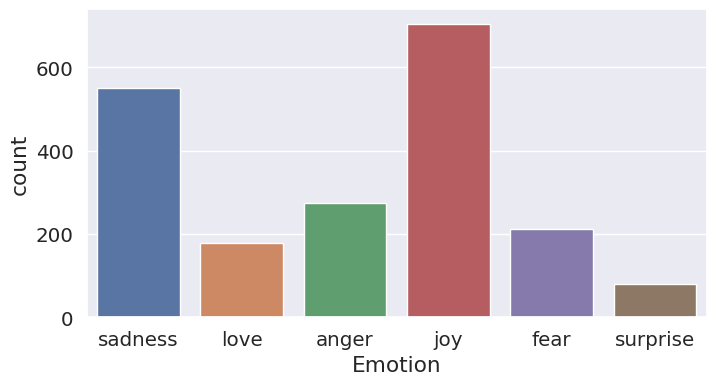

In [34]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df_val, x='Emotion')

In [35]:
df_val.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [36]:
df_val.duplicated().sum()

0

In [37]:
df_val[df_val['Text'].duplicated() == True]

,Text,Emotion
603,i have had several new members tell me how com...,joy
1993,i feel so tortured by it,anger


In [38]:
df_val[df_val['Text'] == df_val.iloc[603]['Text']] 

,Text,Emotion
300,i have had several new members tell me how com...,love
603,i have had several new members tell me how com...,joy


In [39]:
df_val[df_val['Text'] == df_val.iloc[1993]['Text']] 

,Text,Emotion
774,i feel so tortured by it,fear
1993,i feel so tortured by it,anger


In [40]:
index = df_val[df_val['Text'].duplicated() == True].index
df_val.drop(index, axis=0, inplace=True)
df_val.reset_index(inplace=True, drop=True)

In [41]:
df_val[df_val['Text'].duplicated() == True]

,Text,Emotion


In [42]:
temp = df_val.copy()
temp['stop_words'] = temp['Text'].apply(lambda x : len(set(stop_words) & set(x.split())))
temp['stop_words'].value_counts()

stop_words
7     190
5     175
8     173
6     160
3     160
10    150
9     146
4     145
2     133
11    103
12     76
13     74
1      64
14     63
15     44
16     36
17     31
18     21
19     16
20     16
0      11
21      6
22      3
23      2
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

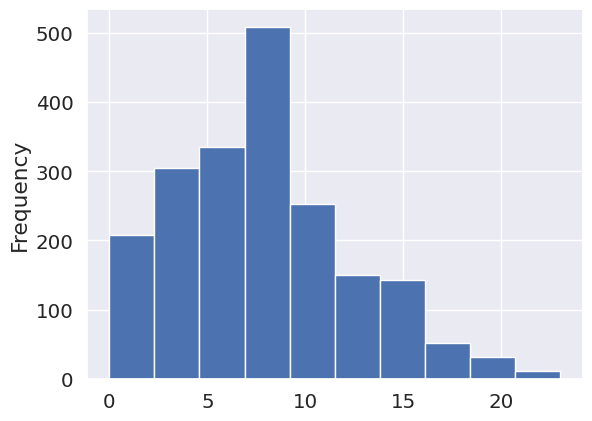

In [43]:
sns.set(font_scale=1.3)
temp['stop_words'].plot(kind='hist')

In [44]:
def dataframe_difference(df1, df2, which=None):
    comparision_df = df1.merge(
        df2, 
        indicator=True,
        how='outer'
    )
    
    if which is None:
        diff_df = comparision_df[comparision_df['_merge'] != 'both']
    else:
        diff_df = comparision_df[comparision_df['_merge'] == which]
        
    return diff_df

In [45]:
dataframe_difference(df_train, df_test, 'both')

,Text,Emotion,_merge


In [46]:
dataframe_difference(df_train, df_val, which='both')

,Text,Emotion,_merge


In [47]:
dataframe_difference(df_val, df_test, which='both')

,Text,Emotion,_merge


In [48]:
def lemmatization(text):
    lemmatizer= WordNetLemmatizer()

    text = text.split()

    text=[lemmatizer.lemmatize(y) for y in text]
    
    return " " .join(text)

def remove_stop_words(text):

    Text=[i for i in str(text).split() if i not in stop_words]
    return " ".join(Text)

def Removing_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

def lower_case(text):
    
    text = text.split()

    text=[y.lower() for y in text]
    
    return " " .join(text)

def Removing_punctuations(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"", )
    
    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    text =  " ".join(text.split())
    return text.strip()

def Removing_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_small_sentences(df):
    for i in range(len(df)):
        if len(df.text.iloc[i].split()) < 3:
            df.text.iloc[i] = np.nan
            
def normalize_text(df):
    df.Text=df.Text.apply(lambda text : lower_case(text))
    df.Text=df.Text.apply(lambda text : remove_stop_words(text))
    df.Text=df.Text.apply(lambda text : Removing_numbers(text))
    df.Text=df.Text.apply(lambda text : Removing_punctuations(text))
    df.Text=df.Text.apply(lambda text : Removing_urls(text))
    df.Text=df.Text.apply(lambda text : lemmatization(text))
    return df

def normalized_sentence(sentence):
    sentence= lower_case(sentence)
    sentence= remove_stop_words(sentence)
    sentence= Removing_numbers(sentence)
    sentence= Removing_punctuations(sentence)
    sentence= Removing_urls(sentence)
    sentence= lemmatization(sentence)
    return sentence

In [49]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [50]:
normalized_sentence("My Name is Mohamed. @Tweets,  plays 2022  Egypt_")

'name mohamed tweet play egypt'

In [51]:
df_train= normalize_text(df_train)
df_test= normalize_text(df_test)
df_val= normalize_text(df_val)


In [52]:
df_train.head()

,Text,Emotion
0,didnt feel humiliated,sadness
1,go feeling hopeless damned hopeful around some...,sadness
2,im grabbing minute post feel greedy wrong,anger
3,ever feeling nostalgic fireplace know still pr...,love
4,feeling grouchy,anger


In [53]:
X_train = df_train['Text']
y_train = df_train['Emotion']

X_test = df_test['Text']
y_test = df_test['Emotion']

X_val = df_val['Text']
y_val = df_val['Emotion']

In [54]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

In [55]:
print(set(y_train))

{0, 1, 2, 3, 4, 5}


In [56]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [57]:
tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))

In [ ]:
tokenizer.word_counts

In [59]:
tokenizer.document_count

17969

In [60]:
tokenizer.word_index['go']

31

In [114]:
tokenizer.texts_to_sequences(X_train[0].split())

AttributeError: 'numpy.ndarray' object has no attribute 'split'

In [62]:
tokenizer.texts_to_matrix(X_train[0].split()).shape

(3, 14325)

In [63]:
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

In [64]:
len(sequences_train)

15969

In [65]:
max_len = max([len(text) for text in df_train['Text']])
max_len

229

In [66]:
X_train = pad_sequences(sequences_train, maxlen=max_len, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=max_len, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=max_len, truncating='pre')

In [67]:
vocabSize = len(tokenizer.index_word) + 1
print(f"The vocab size is {vocabSize}")

The vocab size is 14325


In [80]:
path_to_glove_file = '/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt'
num_tokens = vocabSize
embedding_dim = 200
hits = 0
misses = 0
embedding_index = {}

In [82]:
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embedding_index[word] = coefs

print(f"Found {len(embedding_index)} word vectors")

embedding_matrix = np.zeros((num_tokens, embedding_dim ))

for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1

print(f"Converted {hits} word, missed {misses} words")

Found 400000 word vectors
Converted 26486 word, missed 2162 words


In [102]:
adam = Adam(learning_rate=0.005)

model = Sequential()
model.add(Embedding(vocabSize, 200, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(256, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2)))
model.add(Dense(6, activation='softmax'))

model.build(
    input_shape=(None, X_train.shape[1])
)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 229, 200)       │     2,865,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ (None, 229, 512)       │       935,936 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_16                │ (None, 229, 256)       │       656,384 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_17                │ (None, 256)            │       394,240 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,853,102 (18.51 MB)

 Trainable params: 1,988,102 (7.58 MB)

 Non-trainable params: 2,865,000 (10.93 MB)

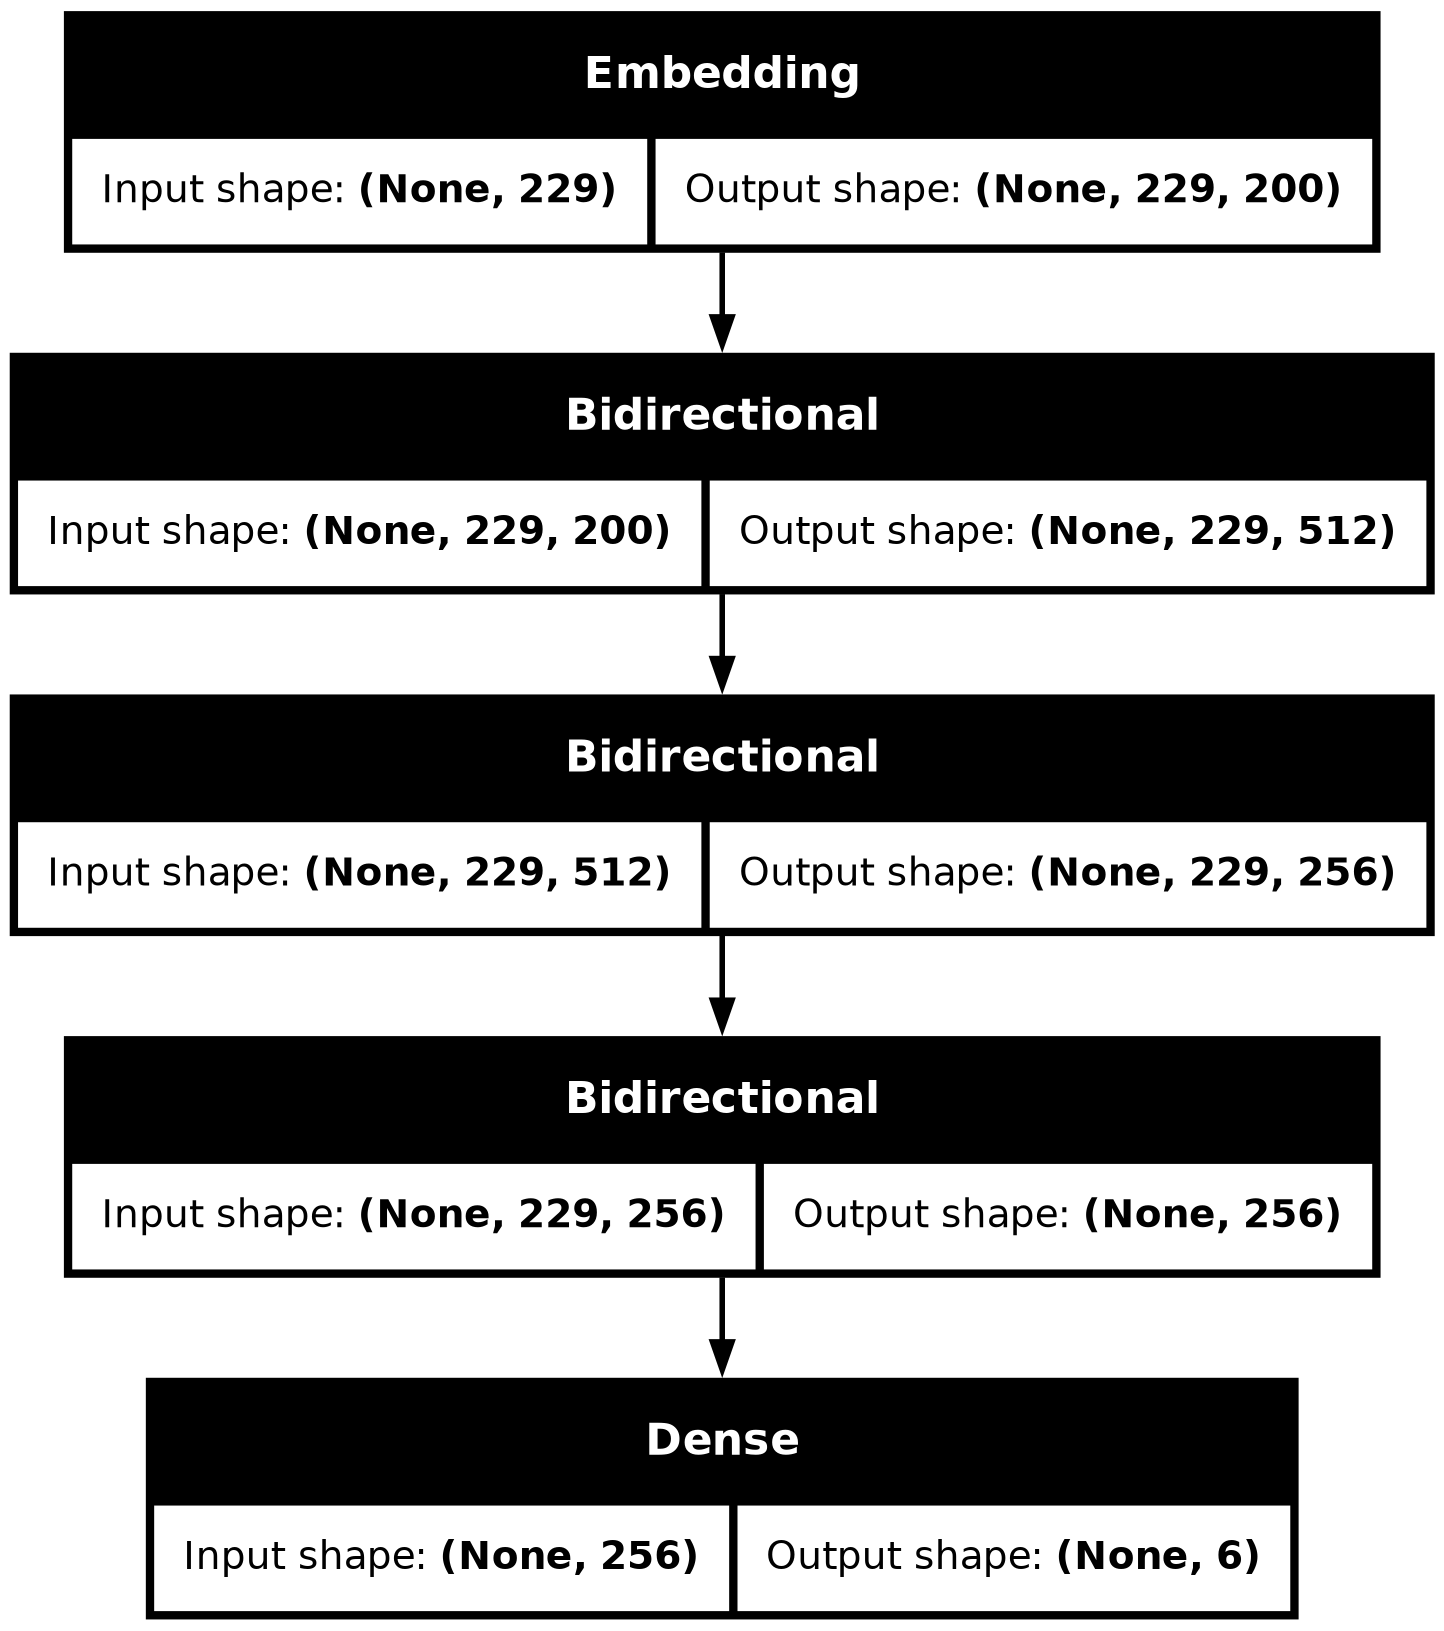

In [103]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [104]:
callback = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

In [105]:
history = model.fit(
    X_train, 
    y_train,
    validation_data=(X_val, y_val),
    verbose=True,
    batch_size=256,
    epochs=30,
    callbacks=[callback]
)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 567s 9s/step - accuracy: 0.4336 - loss: 1.4319 - val_accuracy: 0.8163 - val_loss: 0.5403
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 554s 9s/step - accuracy: 0.8186 - loss: 0.5172 - val_accuracy: 0.8994 - val_loss: 0.2701
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 564s 9s/step - accuracy: 0.9000 - loss: 0.2675 - val_accuracy: 0.9139 - val_loss: 0.1898
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 556s 9s/step - accuracy: 0.9232 - loss: 0.1800 - val_accuracy: 0.9234 - val_loss: 0.1608
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 556s 9s/step - accuracy: 0.9364 - loss: 0.1326 - val_accuracy: 0.9274 - val_loss: 0.1398
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 553s 9s/step - accuracy: 0.9465 - loss: 0.1144 - val_accuracy: 0.9294 - val_loss: 0.1466
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 546s 9s/step - accuracy: 0.9404 - loss: 0.1204 - val_accuracy: 0.9339 - val_loss: 0.1297
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 548s 9s/step - accuracy: 0.9501 - loss: 0.1022 - val_accuracy: 0.9374 - v

In [106]:
model.evaluate(X_val, y_val, verbose=1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 36s 572ms/step - accuracy: 0.9524 - loss: 0.0976


[0.11716201156377792, 0.9429429173469543]

In [108]:
predicted = model.predict(X_test)
y_pred = predicted.argmax(axis=-1)

print(classification_report(le.transform(df_test['Emotion']), y_pred))

63/63 ━━━━━━━━━━━━━━━━━━━━ 36s 577ms/step
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       275
           1       0.89      0.88      0.88       224
           2       0.94      0.95      0.95       695
           3       0.86      0.79      0.82       159
           4       0.98      0.95      0.96       581
           5       0.72      0.79      0.75        66

    accuracy                           0.93      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.93      0.93      0.92      2000



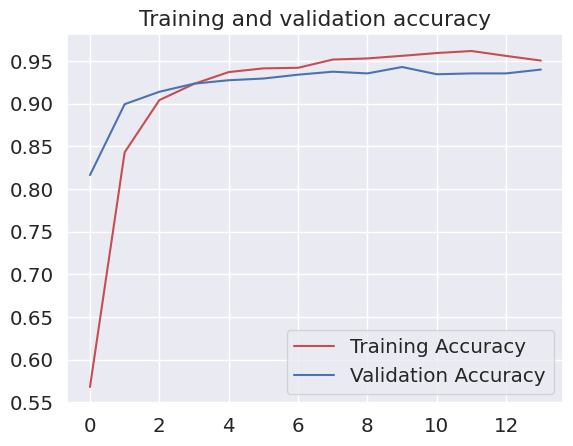

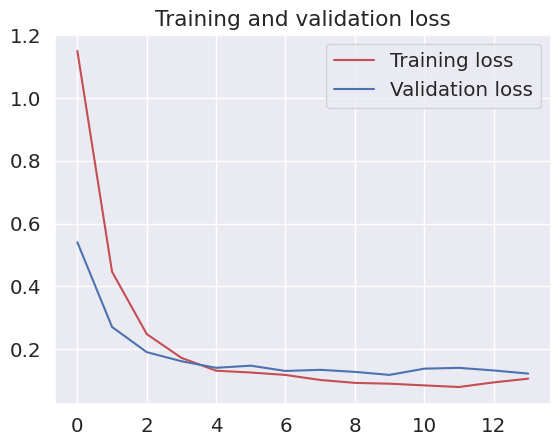

In [109]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [110]:
sentences = [
            "He's over the moon about being accepted to the university",
            "Your point on this certain matter made me outrageous, how can you say so? This is insane.",
            "I can't do it, I'm not ready to lose anything, just leave me alone",
            "Merlin's beard harry, you can cast the Patronus charm! I'm amazed!"
            ]

for sentence in sentences:
    print(sentence)
    sentence = normalized_sentence(sentence)
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=229, truncating='pre')
    result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba = np.max(model.predict(sentence))
    
    print(f"{result} : {proba}")
    

He's over the moon about being accepted to the university
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
joy : 0.9500458240509033
Your point on this certain matter made me outrageous, how can you say so? This is insane.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
anger : 0.4064067602157593
I can't do it, I'm not ready to lose anything, just leave me alone
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
sadness : 0.38136789202690125
Merlin's beard harry, you can cast the Patronus charm! I'm amazed!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
surprise : 0.9875868558883667


In [111]:
model.save('Emotion Recognition From English text.h5')